# Neural Network Classification

- Binary Classification
> Target can be one of two options, e.g. yes or no
- Multi class Classification
> Target can be one of more than two options
- Multi label Classification
> Target can be assigned more than one option

# 1.Binary classification data ready
> Data can be almost anything but to get started we're going to create a simple binary classification dataset.

In [1]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise = 0.03, # a little bit of noise to the dots
                    random_state=42) # keep random state so we get the same values

In [2]:
X.shape, y.shape

((1000, 2), (1000,))

In [3]:
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels:
[1 1 1 1 0]


In [4]:
# Make DataFrame of circle data
import pandas as pd

circles = pd.DataFrame({"X1" : X[:, 0],
                        "X2": X[:, 1],
                        "label": y
                        })
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


In [5]:
# Check different labels
circles.label.value_counts()

1    500
0    500
Name: label, dtype: int64

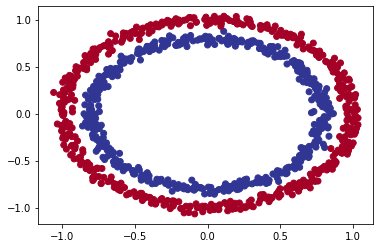

In [9]:
# Visualize with a plot
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu);

# Input and output shapes
one of the most common errors in deep learning is shape errors.
Mismatching the shape of tensors and operations with result in errors in your models.

In [10]:
X.shape, y.shape

((1000, 2), (1000,))

In [11]:
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


# Turn data into tensors and create train and test splits

In [12]:
# Trun data into tensors
# Otherwise this causes issues with computations later on
import torch

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# View ther first five samples
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]), tensor([1., 1., 1., 1., 0.]))

In [14]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproucible

X_train.shape, X_test.shape, y_train.shape, y_test.shape                                                    

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

# 2. Building a Pytorch classification model
> Here we'll create a model to learn patterns in the data, we'll also choose a `loss function`, `optimizer` and build a `training loop` specific to classification.


1. Setting up device agnostic code (so our model can run on CPU or GPU if it's available).
2. Constructing a model by subclassing `nn.Module`.
3. Defining a loss function and optimizer.
4. Creating a training loop

In [17]:
# Standard Pytorch imports
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# Make a model_0

In [24]:
# 1. Construct a model class that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling X and y input and output shapes
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features (X), produces 5 features
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features, produces 1 feature (y)
    
    # 3. Define a forward method containing the forward pass computation
    def forward(self, x):
        # Return the output of layer_2, a single feature, the same shape as y
        layer_1_out = self.layer_1(x)
        layer_2_out = self.layer_2(layer_1_out) # computation goes through layer_1 first then the output of layer_1 goes through layer_2
        return layer_2_out 

In [25]:
# 4. Create an instance of the model and send it to target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [26]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:
import torchinfo

torchinfo.summary(model_0, (1, 2))

Layer (type:depth-idx)                   Output Shape              Param #
CircleModelV0                            [1, 1]                    --
├─Linear: 1-1                            [1, 5]                    15
├─Linear: 1-2                            [1, 1]                    6
Total params: 21
Trainable params: 21
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

# Setup loss function and optimizer

Pytorch has two binary cross entropy implementations:
1. [torch.nn.BCELoss()](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html): Creates a loss function that measures the binary cross entropy between the target (label) and input (features).
2. [torch.nn.BCEWithLogitsLoss()](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html): This is the same as above except it has a sigmoid layer ([nn.Sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html)) built-in (we'll see what this means soon).

In [28]:
# Create a loss function
# loss_fn = nn.BCELoss()
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [29]:
# Calculate accuracy(a classification metric)
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

#3. Fitting the model to data(training)
> We've got data and a model, now let's let the model (try to) find patterns in the (training) data.

## Pytorch training loop steps

1. Forward pass
> The model goes through all of the training data once, performing its `forward()` function calculations (`model(x_train)`).
2. Calculate the loss
> The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are (`loss = loss_fn(y_pred, y_train`). 
3. Zero gradients
> The optimizers gradients are set to zero (they are accumulated by default) so they can be recalculated for the specific training step (`optimizer.zero_grad()`). 
4. Perform backpropagation on the loss
> Computes the gradient of the loss with respect for every model parameter to be updated (each parameter with `requires_grad=True`). This is known as backpropagation, hence "backwards" (`loss.backward()`).
5. Step the optimizer (gradient descent)
> Update the parameters with `requires_grad=True` with respect to the loss gradients in order to improve them (`optimizer.step()`).

#Going from raw model outputs to predicted label

In [30]:
# View the first 5 outputs of the forward pass on the test data
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.2051],
        [-0.3170],
        [ 0.0601],
        [-0.2801],
        [ 0.0154]], grad_fn=<SliceBackward0>)

In [31]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4489],
        [0.4214],
        [0.5150],
        [0.4304],
        [0.5039]], grad_fn=<SigmoidBackward0>)

More specificially:
- If `y_pred_probs` >= 0.5, `y=1` (class 1)
- If `y_pred_probs` < 0.5, `y=0` (class 0)

To turn our prediction probabilties in prediction labels, we can round the outputs of the sigmoid activation function.

In [32]:
#Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

#Get rid of extra dimension
y_preds.squeeze()

tensor([0., 0., 1., 0., 1.], grad_fn=<SqueezeBackward0>)

In [33]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [34]:
torch.eq(y_preds.squeeze(), y_test[:5]) #예측 값과 실제 값 비교

tensor([False,  True,  True,  True,  True])

## Building a training and testing loop

In [37]:
torch.manual_seed(42)

#Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
  ### Training
  model_0.train()

  # 1. Forward pass(model outputs raw logits)
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2. Calculate loss/accuracy
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backwards
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Testing 
  model_0.eval()
  with torch.inference_mode():
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    # 2, Calculate loss
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

  # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")  

Epoch: 0 | Loss: 0.69424, Accuracy: 48.38% | Test loss: 0.69152, Test acc: 53.00%
Epoch: 10 | Loss: 0.69409, Accuracy: 48.38% | Test loss: 0.69164, Test acc: 53.00%
Epoch: 20 | Loss: 0.69396, Accuracy: 47.75% | Test loss: 0.69177, Test acc: 53.00%
Epoch: 30 | Loss: 0.69384, Accuracy: 48.00% | Test loss: 0.69190, Test acc: 51.50%
Epoch: 40 | Loss: 0.69374, Accuracy: 48.50% | Test loss: 0.69202, Test acc: 50.50%
Epoch: 50 | Loss: 0.69366, Accuracy: 48.50% | Test loss: 0.69214, Test acc: 51.50%
Epoch: 60 | Loss: 0.69358, Accuracy: 48.50% | Test loss: 0.69226, Test acc: 51.50%
Epoch: 70 | Loss: 0.69351, Accuracy: 48.62% | Test loss: 0.69237, Test acc: 52.00%
Epoch: 80 | Loss: 0.69346, Accuracy: 48.62% | Test loss: 0.69248, Test acc: 50.50%
Epoch: 90 | Loss: 0.69340, Accuracy: 48.00% | Test loss: 0.69259, Test acc: 50.50%


# 4.Making predictions and evaluating a model (inference)
> Our model's found patterns in the data, let's compare its findings to the actual (testing) data.

In [40]:
import requests
from pathlib import Path


# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

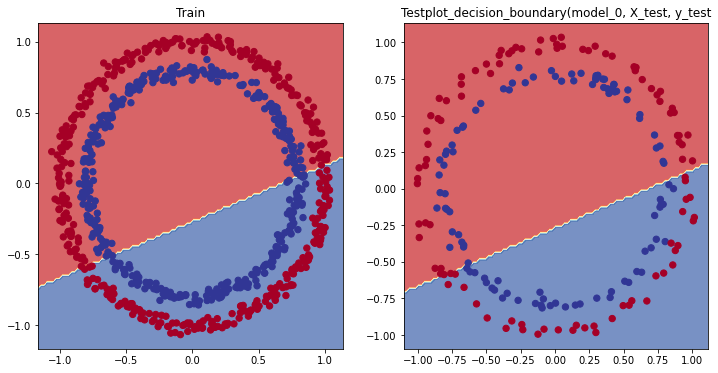

In [43]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Testplot_decision_boundary(model_0, X_test, y_test")
plot_decision_boundary(model_0, X_test, y_test)

#  5.Improving a model(from a model)

In [44]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10) # extra layer
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        
    def forward(self, x): # note: always make sure forward is spelt correctly!
        # Creating a model like this is the same as below, though below
        # generally benefits from speedups where possible.
        # z = self.layer_1(x)
        # z = self.layer_2(z)
        # z = self.layer_3(z)
        # return z
        return self.layer_3(self.layer_2(self.layer_1(x)))

In [45]:
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [46]:
torchinfo.summary(model_1, (1, 2))

Layer (type:depth-idx)                   Output Shape              Param #
CircleModelV1                            [1, 1]                    --
├─Linear: 1-1                            [1, 10]                   30
├─Linear: 1-2                            [1, 10]                   110
├─Linear: 1-3                            [1, 1]                    11
Total params: 151
Trainable params: 151
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [48]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

Fitting for longer(more epochs)

In [52]:
torch.manual_seed(42)

epochs = 1000 # Train for longer

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> predicition probabilities -> prediction labels

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69305, Accuracy: 50.38% | Test loss: 0.69379, Test acc: 48.00%
Epoch: 200 | Loss: 0.69299, Accuracy: 51.12% | Test loss: 0.69437, Test acc: 46.00%
Epoch: 300 | Loss: 0.69298, Accuracy: 51.62% | Test loss: 0.69458, Test acc: 45.00%
Epoch: 400 | Loss: 0.69298, Accuracy: 51.12% | Test loss: 0.69465, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69467, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%


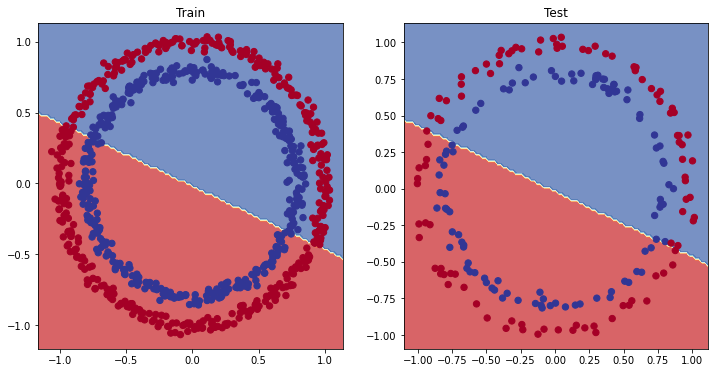

In [53]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

# Preparing data to see if our model can model a straight line

In [54]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # linear regression formula

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]), tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

# Evaluating a model_3 trained

In [55]:
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

print(len(X_train_regression), 
    len(y_train_regression), 
    len(X_test_regression), 
    len(y_test_regression))


80 80 20 20


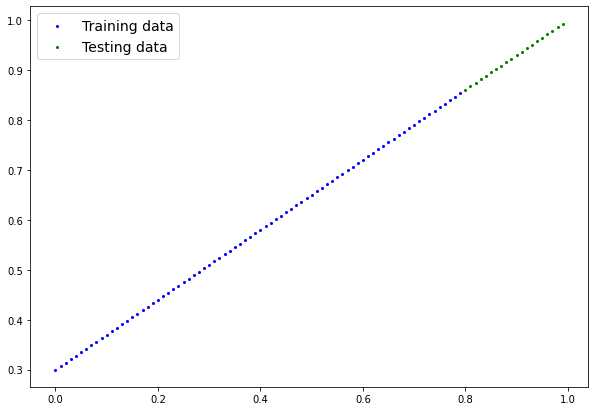

In [56]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression)

# Make a model_2

In [57]:
# Same architecture as model_1 (but using nn.Sequential)
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [58]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)

In [59]:
# Train the model
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
    ### Training 
    # 1. Forward pass
    y_pred = model_2(X_train_regression)
    
    # 2. Calculate loss (no accuracy since it's a regression problem, not classification)
    loss = loss_fn(y_pred, y_train_regression)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_2.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_pred = model_2(X_test_regression)
      # 2. Calculate the loss 
      test_loss = loss_fn(test_pred, y_test_regression)

    # Print out what's happening
    if epoch % 100 == 0: 
        print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")

Epoch: 0 | Train loss: 0.75986, Test loss: 0.54143
Epoch: 100 | Train loss: 0.09309, Test loss: 0.02901
Epoch: 200 | Train loss: 0.07376, Test loss: 0.02850
Epoch: 300 | Train loss: 0.06745, Test loss: 0.00615
Epoch: 400 | Train loss: 0.06107, Test loss: 0.02004
Epoch: 500 | Train loss: 0.05698, Test loss: 0.01061
Epoch: 600 | Train loss: 0.04857, Test loss: 0.01326
Epoch: 700 | Train loss: 0.06109, Test loss: 0.02127
Epoch: 800 | Train loss: 0.05600, Test loss: 0.01425
Epoch: 900 | Train loss: 0.05571, Test loss: 0.00603


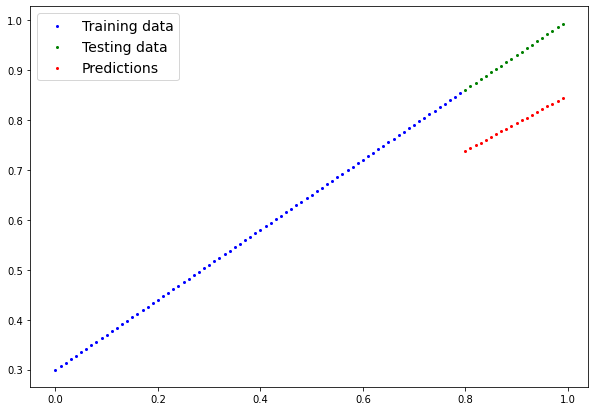

In [60]:
model_2.eval()

# Make predictions(inference)
with torch.inference_mode():
  y_preds = model_2(X_test_regression)

plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu());

# 6.Non-linearity
> So far our model has only had the ability to model straight lines, what about non-linear (non-straight) lines? 

## Recreating non linear data(red and blue)

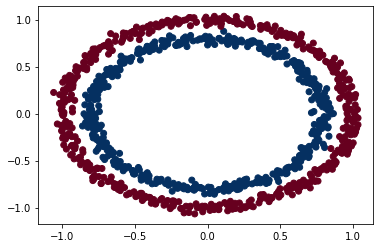

In [61]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=1000,
                    noise=0.03,
                    random_state=42,
                    )
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu);

In [62]:
# Convert to tensors and split into train and test sets
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2,
                                                    random_state=42
)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]), tensor([1., 0., 0., 0., 1.]))

# Make a model_3 with non linearity

In [65]:
from torch import nn

class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU()

  def forward(self, x):
      # Intersperse the ReLU activation function between layers
      # out = self.layer_1(x)
      # out = self.relu(out)
      # out = self.layer_2(out)
      # out = self.relu(out)
      # out = self.layer_3(out)
      # return out 
      return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

In [66]:
model_3 = CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [67]:
model_3 = CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [68]:
torchinfo.summary(model_3, (1, 2))

Layer (type:depth-idx)                   Output Shape              Param #
CircleModelV2                            [1, 1]                    --
├─Linear: 1-1                            [1, 10]                   30
├─ReLU: 1-2                              [1, 10]                   --
├─Linear: 1-3                            [1, 10]                   110
├─ReLU: 1-4                              [1, 10]                   --
├─Linear: 1-5                            [1, 1]                    11
Total params: 151
Trainable params: 151
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

# Evaluating a model_3 trained

In [69]:
#Make predictions
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y[:10]  

(tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

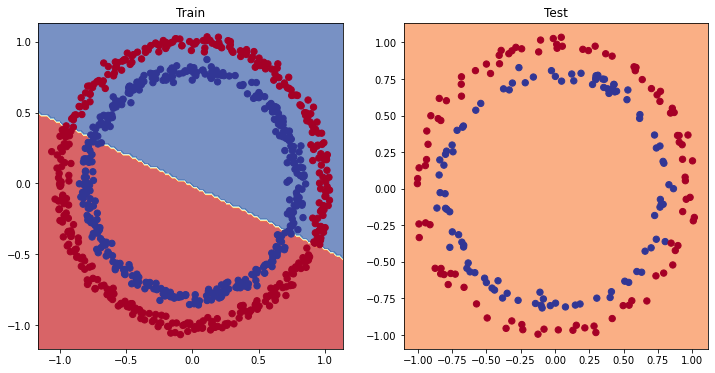

In [70]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

# 7.Multi-class classification